# delhi RAINFALL TREND ANALYSIS

Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### INSTALLING NECESSARY LIBRARIES

In [2]:
!pip install geopandas

In [3]:
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.8/369.8 kB 5.6 MB/s eta 0:00:00


In [4]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512578 sha256=6de832cc3598e3baa3b4c59740fbda430da969f870cdd67e17ab6b7a5d9fdf91
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [5]:
!pip install pymannkendall

In [6]:
!pip install pyhomogeneity

In [7]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

import pyproj
from shapely.geometry import Point

import pandas as pd

from fastdtw import fastdtw

from scipy.stats import kendalltau, norm, linregress

import pyhomogeneity as hg

### IMPLEMENTATION

IMPORTING INDIAN METEROLOGICAL DEPARTMENT (IMD) RAINFALL DATASETS 2022 TO 1901

In [8]:
data_path = '/content/drive/MyDrive/IMD_RAINFALL_DATA/'

In [9]:
rainfall_data_2022 = xr.open_dataset(data_path + '2022.nc')
print(rainfall_data_2022.head())

<xarray.Dataset>
Dimensions:    (LONGITUDE: 5, LATITUDE: 5, TIME: 5)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 66.5 67.5 68.5 69.5 70.5
  * LATITUDE   (LATITUDE) float64 6.5 7.5 8.5 9.5 10.5
  * TIME       (TIME) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-01-05
Data variables:
    RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 ...
Attributes:
    history:      FERRET V7.5 (optimized) 19-Jan-23
    Conventions:  CF-1.6


PRINTING THE LATITUDNAL AND LONGITUDNAL RANGE OF THE RAINFALL DATASETS

In [10]:
# Access the longitude and latitude coordinates from the dataset
longitude_values = rainfall_data_2022['LONGITUDE'].values
latitude_values = rainfall_data_2022['LATITUDE'].values

# Find the minimum and maximum values for longitude and latitude
min_longitude = longitude_values.min()
max_longitude = longitude_values.max()
min_latitude = latitude_values.min()
max_latitude = latitude_values.max()

# Print the range of longitude and latitude
print(f"Longitude Range: ({min_longitude}, {max_longitude})")
print(f"Latitude Range: ({min_latitude}, {max_latitude})")

Longitude Range: (66.5, 100.5)
Latitude Range: (6.5, 38.5)


In [11]:
print(f"Latitude values: {latitude_values}", "\n")

print(f"Longitude values: {longitude_values}")

Latitude values: [ 6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5 15.5 16.5 17.5 18.5 19.5
 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5
 34.5 35.5 36.5 37.5 38.5] 

Longitude values: [ 66.5  67.5  68.5  69.5  70.5  71.5  72.5  73.5  74.5  75.5  76.5  77.5
  78.5  79.5  80.5  81.5  82.5  83.5  84.5  85.5  86.5  87.5  88.5  89.5
  90.5  91.5  92.5  93.5  94.5  95.5  96.5  97.5  98.5  99.5 100.5]


IMPORTING THE SHAPEFILE OF INDIA

In [12]:
India_shapefile_path = '/content/drive/MyDrive/IMD_RAINFALL_DATA/data/india_district.shp'
India_shapefile = gpd.read_file(India_shapefile_path)
print(India_shapefile)

     censuscode    district  dt_cen_cd  st_cen_cd           st_nm  \
0         536.0   Hyderabad          5         28  Andhra Pradesh   
1         494.0         Diu          1         25     Daman & Diu   
2          91.0       North          2          7    NCT of Delhi   
3         191.0    AZAMGARH         61          9   Uttar Pradesh   
4           NaN       HAPUR         73          9   Uttar Pradesh   
..          ...         ...        ...        ...             ...   
640       146.0        AGRA         15          9   Uttar Pradesh   
641       166.0      JHANSI         36          9   Uttar Pradesh   
642       167.0    LALITPUR         37          9   Uttar Pradesh   
643       171.0  CHITRAKOOT         41          9   Uttar Pradesh   
644       199.0    MIRZAPUR         69          9   Uttar Pradesh   

                                              geometry  
0    POLYGON ((78.51164 17.45434, 78.54018 17.46267...  
1                                                 None  


In [13]:
print(India_shapefile['st_nm'].unique())

['Andhra Pradesh' 'Daman & Diu' 'NCT of Delhi' 'Uttar Pradesh'
 'West Bengal' 'Assam' 'Jharkhand' 'Puducherry' 'Tamil Nadu'
 'Jammu & Kashmir' 'Haryana' 'Odisha' 'Bihar' 'Nagaland'
 'Himachal Pradesh' 'Manipur' 'Maharashtra' 'Kerala' 'Madhya Pradesh'
 'Punjab' 'Rajasthan' 'Sikkim' 'Karnataka' 'Chhattisgarh' 'Gujarat'
 'Uttarakhand' 'Mizoram' 'Goa' 'Meghalaya' 'Arunanchal Pradesh'
 'Chandigarh' 'Tripura' 'Andaman & Nicobar Island' 'Lakshadweep'
 'Dadara & Nagar Havelli']






FILTERING delhi'S GEODATAFRAME FROM THE SHAPEFILE OF INDIA

In [14]:
# Filter the GeoDataFrame to get the delhi polygon
delhi_shapefile = India_shapefile[India_shapefile['st_nm'] == 'delhi']
print(delhi_shapefile)

Empty GeoDataFrame
Columns: [censuscode, district, dt_cen_cd, st_cen_cd, st_nm, geometry]
Index: []


PRINTING THE LATITUDNAL AND LONGITUDNAL RANGE OF delhi

In [15]:
min_longitude, min_latitude, max_longitude, max_latitude = 76.1167,27.05,78.4833,29.4833

print(f"Latitude Range: {min_latitude} to {max_latitude}")
print(f"Longitude Range: {min_longitude} to {max_longitude}")

Latitude Range: 27.05 to 29.4833
Longitude Range: 76.1167 to 78.4833


AVERAGE DAILY RAINFALL OF delhi FROM 2022 TO 1901

In [16]:
for year in range(2022, 1900, -1):
  rainfall_data = xr.open_dataset(data_path + f'{year}.nc')
  # Find latitude and longitude indices within the delhi's boundaries
  latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
  longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

  # Slice the rainfall data for delhi
  delhi_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]
  #Calculate the average and sum rainfall for each day over the entire time range
  average_rainfall_per_day = np.mean(delhi_rainfall_data, axis=(1, 2))
  sum_rainfall_per_day = np.sum(delhi_rainfall_data, axis=(1, 2))
  # Plot the average rainfall for each day using a line plot
  plt.figure(figsize=(12, 6))
  plt.plot(np.arange(1, len(average_rainfall_per_day) + 1),average_rainfall_per_day , marker='o', linestyle='-', color='b')
  plt.xlabel('Day of the Year')
  plt.ylabel('Average Rainfall (mm)')
  plt.title(f'Average Daily Rainfall in delhi for {year}')
  plt.grid(True)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

SUM DAILY RAINFALL OF delhi FROM 2022 TO 1901

In [17]:
for year in range(2022, 1900, -1):
  rainfall_data = xr.open_dataset(data_path + f'{year}.nc')
  # Find latitude and longitude indices within the delhi's boundaries
  latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
  longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

  # Slice the rainfall data for delhi
  delhi_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]
  #Calculate the average and sum rainfall for each day over the entire time range
  average_rainfall_per_day = np.mean(delhi_rainfall_data, axis=(1, 2))
  sum_rainfall_per_day = np.sum(delhi_rainfall_data, axis=(1, 2))
  # Plot the sum rainfall for each day using a line plot
  plt.figure(figsize=(12, 6))
  plt.plot(np.arange(1, len(sum_rainfall_per_day) + 1),sum_rainfall_per_day , marker='o', linestyle='-', color='b')
  plt.xlabel('Day of the Year')
  plt.ylabel('Sum Rainfall (mm)')
  plt.title(f'Sum Daily Rainfall in delhi for {year}')
  plt.grid(True)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

 MONTHLY RAINFALL OF delhi FROM 2022 TO 1901 (Using average daily rainfall)

In [18]:
for year in range(2022, 1900, -1):
    # Load the rainfall data for the current year
    rainfall_data = xr.open_dataset(data_path + f'{year}.nc')

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Find latitude and longitude indices within the delhi's boundaries
    latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
    longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

    # Slice the rainfall data for delhi
    delhi_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]
    average_rainfall_per_day = np.mean(delhi_rainfall_data, axis=(1, 2))
    # Resample the data to monthly rainfall
    delhi_monthly_rainfall = average_rainfall_per_day.resample(TIME='1M').sum()

    y_data = delhi_monthly_rainfall.values.squeeze()

    # Plot the monthly rainfall using a line plot
    plt.figure(figsize=(12, 6))
    plt.plot(months, y_data, marker='o', linestyle='-', color='b')
    plt.xlabel('Month')
    plt.ylabel('Rainfall (mm)')
    plt.title(f'Monthly Rainfall in delhi for {year}')
    plt.grid(True)
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

AVERAGE MONTHLY RAINFALL OF delhi FROM 2022 TO 1901 (Using average daily rainfall)

In [19]:
for year in range(2022, 1900, -1):
    # Load the rainfall data for the current year
    rainfall_data = xr.open_dataset(data_path + f'{year}.nc')

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Find latitude and longitude indices within the westbengal's boundaries
    latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
    longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

    # Slice the rainfall data for westbengal
    delhi_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]
    average_rainfall_per_day = np.mean(delhi_rainfall_data, axis=(1, 2))
    # Resample the data to monthly averages
    delhi_monthly_average_rainfall = average_rainfall_per_day.resample(TIME='1M').mean()

    y_data = delhi_monthly_average_rainfall.values.squeeze()

    # Plot the average monthly rainfall using a line plot
    plt.figure(figsize=(12, 6))
    plt.plot(months, y_data, marker='o', linestyle='-', color='b')
    plt.xlabel('Month')
    plt.ylabel('Average Rainfall (mm)')
    plt.title(f'Average Monthly Rainfall in delhi for {year}')
    plt.grid(True)
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

 DYNAMIC TIME WARPING (DTW) FOR ANALYSING THE SIMILARITY OF MONTHLY AVERAGE RAINFALL FROM 2022 TO 1901.
 ##### Lowest peaks : Highest similarity (vice versa)

In [20]:
for year1 in range(2022,1900,-1):
  dfs = []
  # Load the rainfall data for the current years
  rainfall_data1 = xr.open_dataset(data_path + f'{year1}.nc')

  # Find latitude and longitude indices within the delhi's boundaries
  latitude_indices1 = np.where((rainfall_data1['LATITUDE'] >= min_latitude) & (rainfall_data1['LATITUDE'] <= max_latitude))[0]
  longitude_indices1 = np.where((rainfall_data1['LONGITUDE'] >= min_longitude) & (rainfall_data1['LONGITUDE'] <= max_longitude))[0]

  # Slice the rainfall data for delhi
  delhi_rainfall_data1 = rainfall_data1['RAINFALL'][:, latitude_indices1, longitude_indices1]
  average_rainfall_per_day1 = np.mean(delhi_rainfall_data1, axis=(1, 2))
  # Resample the data to monthly averages
  delhi_monthly_average_rainfall1 = average_rainfall_per_day1.resample(TIME='1M').mean()

  for year2 in range(year1-1,1900,-1):

    # Load the rainfall data for the current years
    rainfall_data2 = xr.open_dataset(data_path + f'{year2}.nc')

    # Find latitude and longitude indices within the delhi's boundaries
    latitude_indices2 = np.where((rainfall_data2['LATITUDE'] >= min_latitude) & (rainfall_data2['LATITUDE'] <= max_latitude))[0]
    longitude_indices2 = np.where((rainfall_data2['LONGITUDE'] >= min_longitude) & (rainfall_data2['LONGITUDE'] <= max_longitude))[0]

    # Slice the rainfall data for delhi
    delhi_rainfall_data2 = rainfall_data2['RAINFALL'][:, latitude_indices2, longitude_indices2]
    average_rainfall_per_day2 = np.mean(delhi_rainfall_data2, axis=(1, 2))
    # Resample the data to monthly averages
    delhi_monthly_average_rainfall2 = average_rainfall_per_day2.resample(TIME='1M').mean()

    dtw_distance, _ = fastdtw(delhi_monthly_average_rainfall1, delhi_monthly_average_rainfall2)

    # Store the DTW distance and the corresponding year
    dfs.append({'Year': year2, 'DTW Distance': dtw_distance})

    # Create a DataFrame from the list of dictionaries
    result_df = pd.DataFrame(dfs)

  # Plot the DTW distances
  plt.figure(figsize=(40, 6))
  plt.plot(result_df['Year'], result_df['DTW Distance'], marker='o', linestyle='-', color='b')
  plt.xlabel('Years')
  plt.ylabel('DTW Distance')
  plt.title(f'Similarity of delhi\'s Average Monthly Rainfall of {year1} ')
  plt.xticks(np.arange(min(result_df['Year']), max(result_df['Year']) + 1, 1), rotation=45, ha='right')
  plt.grid(True)
  plt.show()


Output hidden; open in https://colab.research.google.com to view.

MONTHLY RAINFALL & TOTAL ANNUAL RAINFALL FROM 1901 TO 2022

In [21]:
dfs = []

for year in range(1901, 2023):
    # Load the rainfall data for the current year
    rainfall_data = xr.open_dataset(data_path + f'{year}.nc')

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Find latitude and longitude indices within the state's boundaries
    latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
    longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

    # Slice the rainfall data for the state
    delhi_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]

    # Resample the data to monthly averages
    #westbengal_monthly_sum_rainfall = westbengal_rainfall_data.resample(TIME='1M').sum()
    average_rainfall_per_day = np.mean(delhi_rainfall_data, axis=(1, 2))
    delhi_monthly_rainfall = average_rainfall_per_day.resample(TIME='1M').sum()
    df_year = pd.DataFrame({
        'Year': [year] * len(delhi_monthly_rainfall['TIME']),
        'Month': delhi_monthly_rainfall['TIME'].dt.strftime('%b'),
        'Monthly Rainfall': delhi_monthly_rainfall.values.flatten()
    })

    # Append the DataFrame to the list
    dfs.append(df_year)

# Concatenate all DataFrames into a single DataFrame
result_df = pd.concat(dfs, ignore_index=True)

# Pivot the DataFrame to have months as columns
result_df_pivoted = result_df.pivot_table(index='Year', columns='Month', values='Monthly Rainfall', aggfunc='sum', fill_value=0)

# Add a column for Total Annual Rainfall
result_df_pivoted['Total Annual Rainfall'] = result_df_pivoted.sum(axis=1)

# Reset index to make 'Year' a column again
result_df_pivoted = result_df_pivoted.reset_index()

# Display the resulting DataFrame
print(result_df_pivoted)

Month  Year        Apr         Aug        Dec        Feb        Jan  \
0      1901   0.000000  175.079573   3.528155  28.906948  40.605820   
1      1902   3.979911  119.103806   0.000000   0.000000   0.000000   
2      1903   0.000000  131.457079   0.000000   0.000000   9.181536   
3      1904   0.316247  310.126016  17.300698   0.164991   1.771634   
4      1905   2.411210   30.218611   0.451865  16.971360  30.498743   
..      ...        ...         ...        ...        ...        ...   
117    2018  15.658479   95.897530   0.657147   0.029549   1.056768   
118    2019  17.939745  112.607948  11.132798  10.075916  16.041307   
119    2020   8.654355  203.192937   0.333687   4.771694  33.521400   
120    2021   1.368227  133.181351   1.305676   2.526501  26.252349   
121    2022   0.563476   44.011578   0.000000  13.030689  60.326816   

Month         Jul        Jun        Mar        May        Nov        Oct  \
0      135.915058  23.270074   3.377462   2.507274   0.000000   3.55107

In [22]:
mean = np.mean(result_df_pivoted['Total Annual Rainfall'] )
std = np.std(result_df_pivoted['Total Annual Rainfall'] )
print(f"Mean of Total Annual Rainfall: {mean} mm")
print(f"Standard deviation of Total Annual Rainfall: {std} mm")
print(f"Range of Total Annual Rainfall: {mean - std}mm <= Rainfall <= {mean + std}mm")
print('\n')
max_rainfall_year = result_df_pivoted.loc[result_df_pivoted['Total Annual Rainfall'].idxmax(), 'Year']
max_rainfall_value = result_df_pivoted['Total Annual Rainfall'].max()

print(f"Year with the Highest Rainfall: {max_rainfall_year}")
print(f"Highest Rainfall Value: {max_rainfall_value} mm")
print('\n')
min_rainfall_year = result_df_pivoted.loc[result_df_pivoted['Total Annual Rainfall'].idxmin(), 'Year']
min_rainfall_value = result_df_pivoted['Total Annual Rainfall'].min()

print(f"Year with the Lowest Rainfall: {min_rainfall_year}")
print(f"Lowest Rainfall Value: {min_rainfall_value} mm")

Mean of Total Annual Rainfall: 598.8874740832196 mm
Standard deviation of Total Annual Rainfall: 193.74843986550127 mm
Range of Total Annual Rainfall: 405.1390342177183mm <= Rainfall <= 792.6359139487208mm


Year with the Highest Rainfall: 2010
Highest Rainfall Value: 1687.2338140793145 mm


Year with the Lowest Rainfall: 1918
Lowest Rainfall Value: 188.87639428302646 mm


In [23]:
from scipy.stats import zscore

TOTAL ANNUAL RAINFALL ANALYSIS FROM 1901 TO 2022

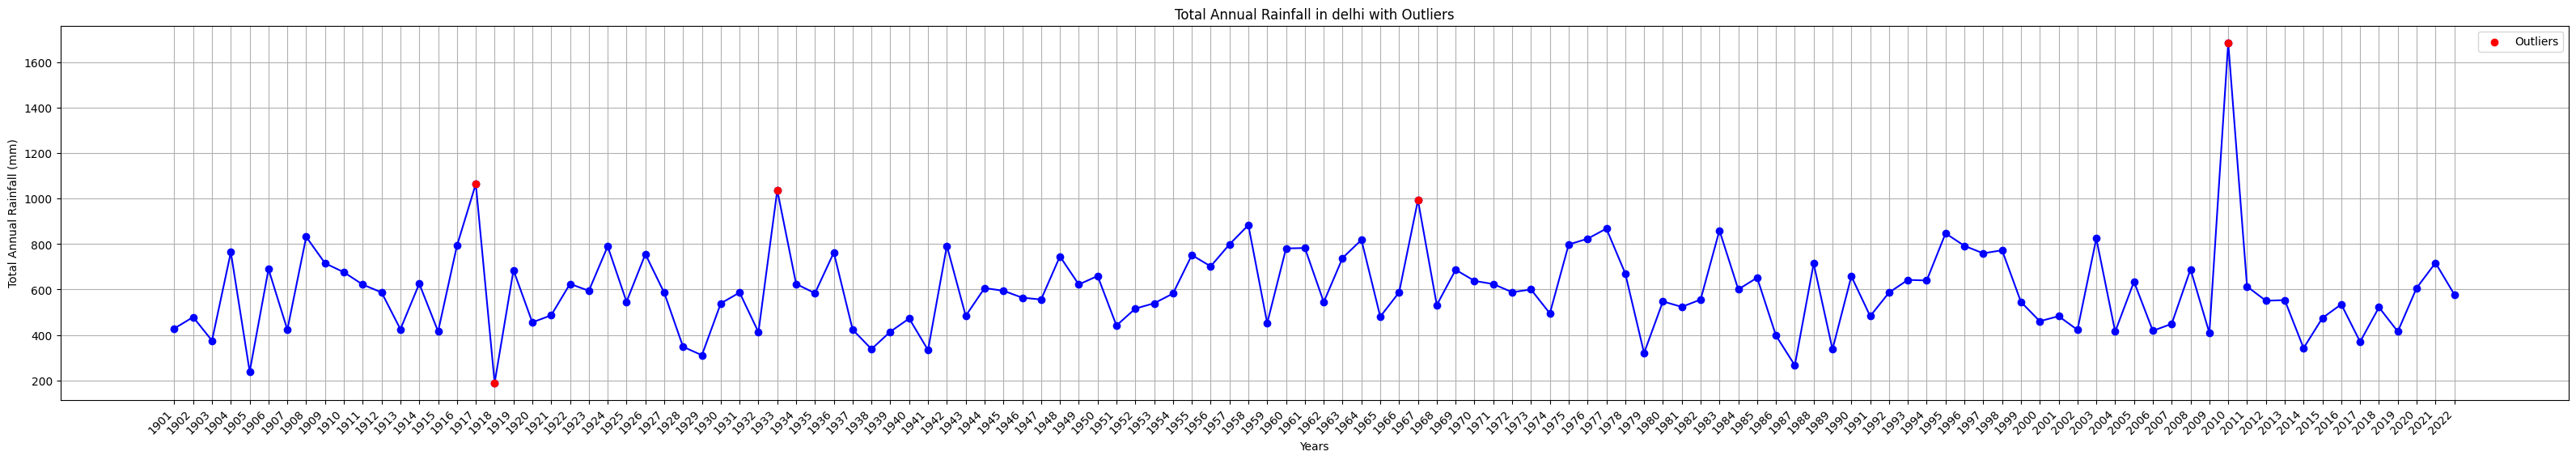

Number of Outliers: 5
Outlier Years: [1917, 1918, 1933, 1967, 2010]
Outlier Values: [1064.9424700755626, 188.87639428302646, 1037.466152973473, 993.7674874458462, 1687.2338140793145]


In [24]:
# Calculate the Z-scores for the 'Total Annual Rainfall' column
z_scores = zscore(result_df_pivoted['Total Annual Rainfall'])

# Define a threshold for identifying outliers (e.g., Z-score greater than 2)
outlier_threshold = 2

# Identify outlier indices
outlier_indices = np.where(np.abs(z_scores) > outlier_threshold)[0]

# Plot the line graph with outliers highlighted
plt.figure(figsize=(40, 6))
plt.plot(result_df_pivoted['Year'], result_df_pivoted['Total Annual Rainfall'], marker='o', linestyle='-', color='b')
plt.scatter(result_df_pivoted['Year'].iloc[outlier_indices], result_df_pivoted['Total Annual Rainfall'].iloc[outlier_indices], color='r', label='Outliers',  zorder=5)
plt.xlabel('Years')
plt.ylabel('Total Annual Rainfall (mm)')
plt.title('Total Annual Rainfall in delhi with Outliers')
plt.xticks(np.arange(min(result_df_pivoted['Year']), max(result_df_pivoted['Year']) + 1, 1), rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()

# Print information about outliers
print(f"Number of Outliers: {len(outlier_indices)}")
print(f"Outlier Years: {result_df_pivoted['Year'].iloc[outlier_indices].tolist()}")
print(f"Outlier Values: {result_df_pivoted['Total Annual Rainfall'].iloc[outlier_indices].tolist()}")

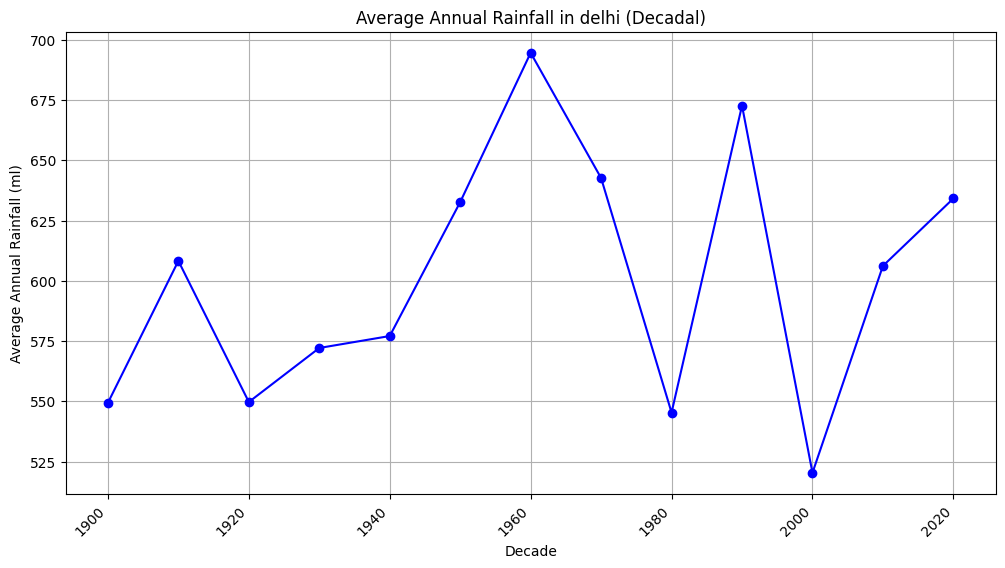

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Assuming you have a DataFrame named result_df_pivoted with columns 'Year' and 'Total Annual Rainfall'
# Adjust column names based on your actual data structure

# Calculate average annual rainfall across each 10 years
result_df_pivoted['Decade'] = (result_df_pivoted['Year'] // 10) * 10
decadal_average_rainfall = result_df_pivoted.groupby('Decade')['Total Annual Rainfall'].mean()

# Plot the decadal average annual rainfall as a line plot
plt.figure(figsize=(12, 6))
plt.plot(decadal_average_rainfall.index, decadal_average_rainfall, marker='o', color='b', linestyle='-')
plt.xlabel('Decade')
plt.ylabel('Average Annual Rainfall (ml)')
plt.title(f'Average Annual Rainfall in delhi (Decadal)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

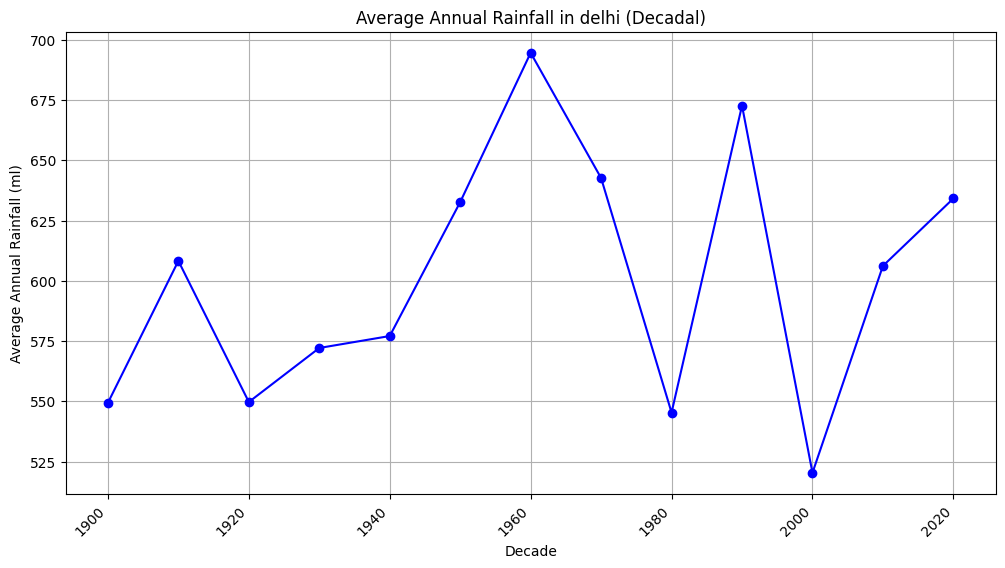

Mean of all data points: 598.8874740832196 ml
Standard Deviation of all data points: 193.74843986550127 ml


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Assuming you have a DataFrame named result_df_pivoted with columns 'Year' and 'Total Annual Rainfall'
# Adjust column names based on your actual data structure

# Calculate average annual rainfall across each 10 years
result_df_pivoted['Decade'] = (result_df_pivoted['Year'] // 10) * 10
decadal_average_rainfall = result_df_pivoted.groupby('Decade')['Total Annual Rainfall'].mean()

# Plot the decadal average annual rainfall as a line plot
plt.figure(figsize=(12, 6))
plt.plot(decadal_average_rainfall.index, decadal_average_rainfall, marker='o', color='b', linestyle='-')
plt.xlabel('Decade')
plt.ylabel('Average Annual Rainfall (ml)')
plt.title(f'Average Annual Rainfall in delhi (Decadal)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

# Calculate the mean and standard deviation of every data point
all_values = result_df_pivoted.groupby('Decade')['Total Annual Rainfall'].agg(list)
all_values_flat = [val for sublist in all_values for val in sublist]

mean_all_values = np.mean(all_values_flat)
std_all_values = np.std(all_values_flat)

print(f"Mean of all data points: {mean_all_values} ml")
print(f"Standard Deviation of all data points: {std_all_values} ml")




MONTHLY RAINFALL ANALYSIS FROM 1901 TO 2022

In [29]:
for month in months:
  # Calculate the Z-scores for the 'month' column
  z_scores = zscore(result_df_pivoted[month])

  # Define a threshold for identifying outliers (e.g., Z-score greater than 2)
  outlier_threshold = 2

  # Identify outlier indices
  outlier_indices = np.where(np.abs(z_scores) > outlier_threshold)[0]

  # Plot the line graph with outliers highlighted
  plt.figure(figsize=(40, 6))
  plt.plot(result_df_pivoted['Year'], result_df_pivoted[month], marker='o', linestyle='-', color='b')
  plt.scatter(result_df_pivoted['Year'].iloc[outlier_indices], result_df_pivoted[month].iloc[outlier_indices], color='r', label='Outliers',  zorder=5)
  plt.xlabel('Years')
  plt.ylabel('Monthly Rainfall (mm)')
  plt.title(f'Monthly Rainfall in Delhi on {month} with Outliers')
  plt.xticks(np.arange(min(result_df_pivoted['Year']), max(result_df_pivoted['Year']) + 1, 1), rotation=45, ha='right')
  plt.legend()
  plt.grid(True)
  plt.show()

  # Print information about outliers
  print(f"Number of Outliers: {len(outlier_indices)}")
  print(f"Outlier Years: {result_df_pivoted['Year'].iloc[outlier_indices].tolist()}")
  print(f"Outlier Values: {result_df_pivoted[month].iloc[outlier_indices].tolist()}")

Output hidden; open in https://colab.research.google.com to view.

TOTAL ANNUAL RAINFALL ANALYSIS FROM 1901 TO 2022

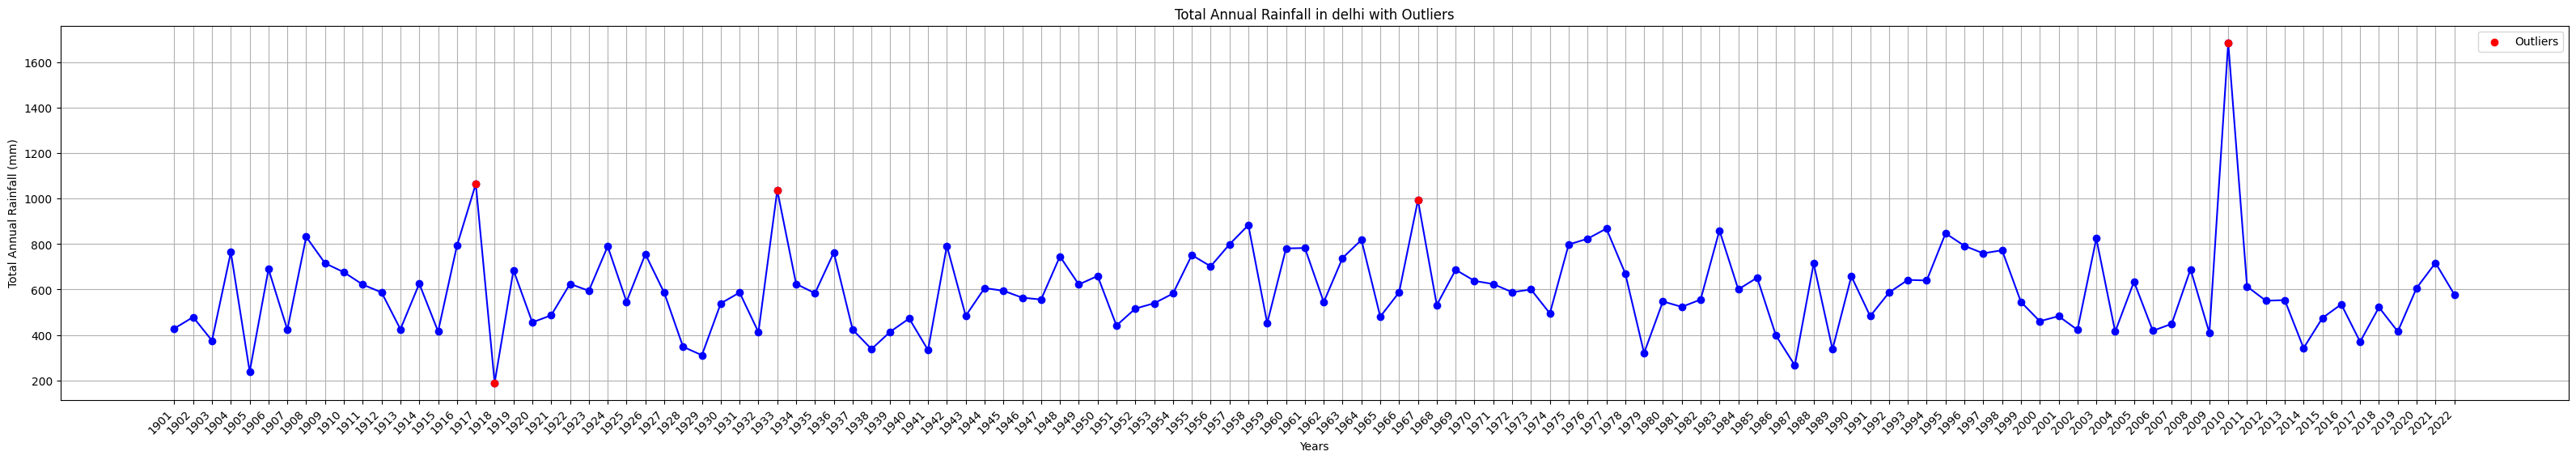

Number of Outliers: 5
Outlier Years: [1917, 1918, 1933, 1967, 2010]
Outlier Values: [1064.9424700755626, 188.87639428302646, 1037.466152973473, 993.7674874458462, 1687.2338140793145]


In [30]:
# Calculate the Z-scores for the 'Total Annual Rainfall' column
z_scores = zscore(result_df_pivoted['Total Annual Rainfall'])

# Define a threshold for identifying outliers (e.g., Z-score greater than 2)
outlier_threshold = 2

# Identify outlier indices
outlier_indices = np.where(np.abs(z_scores) > outlier_threshold)[0]

# Plot the line graph with outliers highlighted
plt.figure(figsize=(40, 6))
plt.plot(result_df_pivoted['Year'], result_df_pivoted['Total Annual Rainfall'], marker='o', linestyle='-', color='b')
plt.scatter(result_df_pivoted['Year'].iloc[outlier_indices], result_df_pivoted['Total Annual Rainfall'].iloc[outlier_indices], color='r', label='Outliers',  zorder=5)
plt.xlabel('Years')
plt.ylabel('Total Annual Rainfall (mm)')
plt.title('Total Annual Rainfall in delhi with Outliers')
plt.xticks(np.arange(min(result_df_pivoted['Year']), max(result_df_pivoted['Year']) + 1, 1), rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()

# Print information about outliers
print(f"Number of Outliers: {len(outlier_indices)}")
print(f"Outlier Years: {result_df_pivoted['Year'].iloc[outlier_indices].tolist()}")
print(f"Outlier Values: {result_df_pivoted['Total Annual Rainfall'].iloc[outlier_indices].tolist()}")

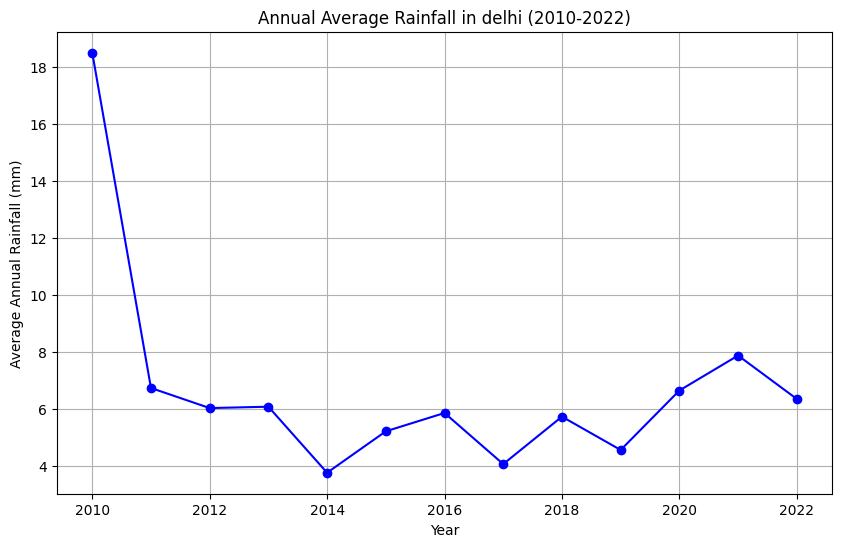

Years above 95th percentile: [2010]
Years below 5th percentile: [2014]


In [31]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr



# Initialize an empty list to store annual average rainfall
annual_averages = []

# Loop through each year in the specified range (2010 to 2022)
for year in range(2010,2023):
    # Load the rainfall data for the current year
    rainfall_data = xr.open_dataset(data_path + f'{year}.nc')

    # Find latitude and longitude indices within Karnataka's boundaries
    latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
    longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

    # Slice the rainfall data for Karnataka
    delhi_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]

    # Calculate the annual average rainfall
    annual_average_rainfall = delhi_rainfall_data.mean(dim='TIME').sum().item()
    annual_averages.append(annual_average_rainfall)

    # Close the NetCDF dataset to free up resources
    rainfall_data.close()

# Plot the annual average rainfall
plt.figure(figsize=(10, 6))
plt.plot(range(2010, 2023), annual_averages, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Average Annual Rainfall (mm)')
plt.title('Annual Average Rainfall in delhi (2010-2022)')
plt.grid(True)
plt.show()

# Calculate percentiles
percentile_5 = np.percentile(annual_averages, 5)
percentile_95 = np.percentile(annual_averages, 95)

# Print years above 95th percentile
above_95 = [year for year, avg in zip(range(2010, 2023), annual_averages) if avg > percentile_95]
print(f'Years above 95th percentile: {above_95}')

# Print years below 5th percentile
below_5 = [year for year, avg in zip(range(2010, 2023), annual_averages) if avg < percentile_5]
print(f'Years below 5th percentile: {below_5}')

AVERAGE ANNUAL RAINFALL OF Delhi(10 YEAR WINDOW)

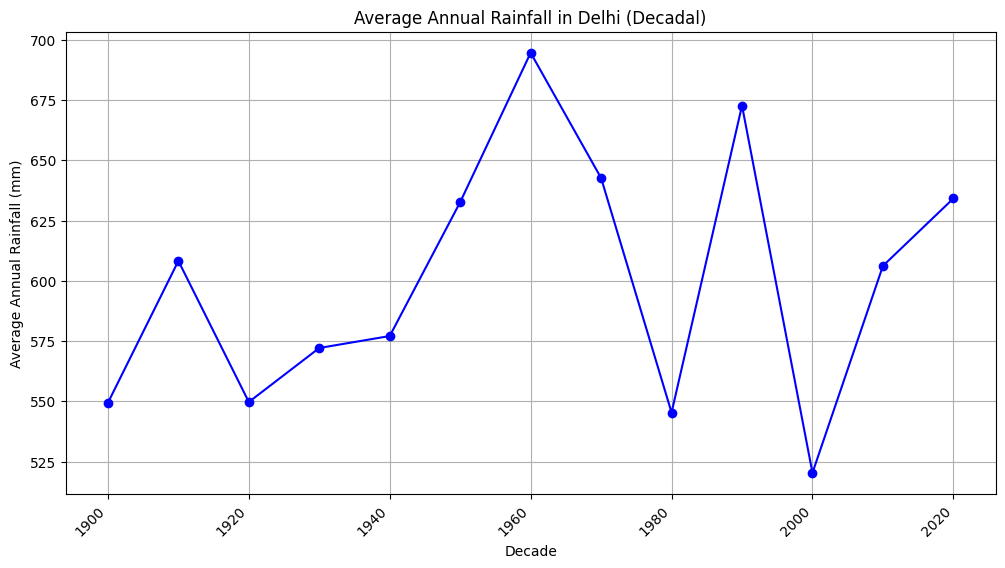

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Assuming you have a DataFrame named result_df_pivoted with columns 'Year' and 'Total Annual Rainfall'
# Adjust column names based on your actual data structure

# Calculate average annual rainfall across each 10 years
result_df_pivoted['Decade'] = (result_df_pivoted['Year'] // 10) * 10
decadal_average_rainfall = result_df_pivoted.groupby('Decade')['Total Annual Rainfall'].mean()

# Plot the decadal average annual rainfall as a line plot
plt.figure(figsize=(12, 6))
plt.plot(decadal_average_rainfall.index, decadal_average_rainfall, marker='o', color='b', linestyle='-')
plt.xlabel('Decade')
plt.ylabel('Average Annual Rainfall (mm)')
plt.title(f'Average Annual Rainfall in Delhi (Decadal)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

FINDING MEAN AND STANDARD DEVIATION OF THE ABOVE CODE

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Assuming you have a DataFrame named result_df_pivoted with columns 'Year' and 'Total Annual Rainfall'
# Adjust column names based on your actual data structure

# Calculate average annual rainfall across each 10 years
result_df_pivoted['Decade'] = (result_df_pivoted['Year'] // 10) * 10
decadal_average_rainfall = result_df_pivoted.groupby('Decade')['Total Annual Rainfall'].mean()

# Print the mean and standard deviation
mean_rainfall = decadal_average_rainfall.mean()
std_rainfall = decadal_average_rainfall.std()

print(f"Mean Annual Rainfall: {mean_rainfall} mm")
print(f"Standard Deviation of Annual Rainfall: {std_rainfall} mm")


Mean Annual Rainfall: 600.4071099700867 mm
Standard Deviation of Annual Rainfall: 53.33715389983848 mm


MANN-KENDALL TEST AND SEN SLOPE ESTIMATOR FOR TREND ANALYSIS.
##### Mann-Kendall test : A non-parametric statistical test used to assess the presence of trends in time series data by evaluating the monotonicity of the data over time.

##### Sen Slope Estimator : A method for estimating the slope of a trend in time series data

In [34]:
# Filter the DataFrame for the desired years (2022 to 2012)
print("Enter the range of years(year1 to year2)")
year1 = int(input())
year2 = int(input())
selected_years = range(year1, year2 + 1)
df_selected_years = result_df_pivoted[result_df_pivoted['Year'].isin(selected_years)]

result, _ = kendalltau(df_selected_years['Year'],df_selected_years['Total Annual Rainfall'])

# Calculate p-value for the Mann-Kendall test
p_value = 2 * norm.cdf(-abs(result))

result_s = linregress(df_selected_years['Year'], df_selected_years['Total Annual Rainfall'])

# Display Mann-Kendall test result
print(f"Mann-Kendall Test Result for Yearly Sum of Rainfall ({year1} to {year2}):")
#print(f"Kendall's Tau: {result}")
print(f"P-value: {p_value}")

# Display Theil-Sen estimator result
print(f"Theil-Sen Estimator Result for Yearly Sum of Rainfall ({year1} to {year2}):")
print(f"Slope (Sen's Slope): {result_s.slope}")

if p_value < 0.05:
    if result_s.slope > 0:
        print("Significant positive trend")
    elif result_s.scope < 0:
        print("Significant negative trend")
    else:
        print("No significant trend")
else:
    print("No significant trend")

Enter the range of years(year1 to year2)
1950
2000
Mann-Kendall Test Result for Yearly Sum of Rainfall (1950 to 2000):
P-value: 0.9818536020954085
Theil-Sen Estimator Result for Yearly Sum of Rainfall (1950 to 2000):
Slope (Sen's Slope): -0.9743844987098044
No significant trend


In [35]:
# Filter the DataFrame for the desired years (2022 to 2012)
print("Enter the range of years(year1 to year2)")
year1 = int(input())
year2 = int(input())
selected_years = range(year1, year2 + 1)
df_selected_years = result_df_pivoted[result_df_pivoted['Year'].isin(selected_years)]

result, _ = kendalltau(df_selected_years['Year'],df_selected_years['Jan'])

# Calculate p-value for the Mann-Kendall test
p_value = 2 * norm.cdf(-abs(result))

result_s = linregress(df_selected_years['Year'], df_selected_years['Jan'])

# Display Mann-Kendall test result
print(f"Mann-Kendall Test Result for Monthly Rainfall of January ({year1} to {year2}):")
#print(f"Kendall's Tau: {result}")
print(f"P-value: {p_value}")

# Display Theil-Sen estimator result
print(f"Theil-Sen Estimator Result for Monthly Rainfall of January ({year1} to {year2}):")
print(f"Slope (Sen's Slope): {result_s.slope}")

if p_value < 0.05:
    if result_s.slope > 0:
        print("Significant positive trend")
    elif result_s.scope < 0:
        print("Significant negative trend")
    else:
        print("No significant trend")
else:
    print("No significant trend")

Enter the range of years(year1 to year2)
1950
2000
Mann-Kendall Test Result for Monthly Rainfall of January (1950 to 2000):
P-value: 0.9320955597597091
Theil-Sen Estimator Result for Monthly Rainfall of January (1950 to 2000):
Slope (Sen's Slope): -0.11493734879242215
No significant trend


PETTITT TEST
##### A non-parametric statistical test used to detect a change point or discontinuity in a time series, indicating a significant shift in the distribution of the data.

In [36]:
# Filter the DataFrame for the desired years (2022 to 2012)
print("Enter the range of years (year1 to year2)")
year1 = int(input())
year2 = int(input())
selected_years = range(year1, year2 + 1)
df_selected_years = result_df_pivoted[result_df_pivoted['Year'].isin(selected_years)]

# Perform Pettitt test for the selected years
result_pettitt = hg.pettitt_test(df_selected_years['Total Annual Rainfall'])

# Display Pettitt test result
print(f"Pettitt Test Result for Yearly Sum of Rainfall ({year1} to {year2}):")
print(f"Change detected: {result_pettitt.h}")
print(f"Change point index: {result_pettitt.cp}")
print(f"P-value: {result_pettitt.p}")
print(f"Test Statistic (U): {result_pettitt.U}")
print(f"Mean Before Change (mu1): {result_pettitt.avg.mu1}")
print(f"Mean After Change (mu2): {result_pettitt.avg.mu2}")

Enter the range of years (year1 to year2)
1950
2000
Pettitt Test Result for Yearly Sum of Rainfall (1950 to 2000):
Change detected: False
Change point index: 29
P-value: 0.5634
Test Statistic (U): 152.0
Mean Before Change (mu1): 668.2629111651974
Mean After Change (mu2): 589.126467091878


In [37]:
# Filter the DataFrame for the desired years (2022 to 2012)
print("Enter the range of years (year1 to year2)")
year1 = int(input())
year2 = int(input())
selected_years = range(year1, year2 + 1)
df_selected_years = result_df_pivoted[result_df_pivoted['Year'].isin(selected_years)]

# Perform Pettitt test for the selected years
result_pettitt = hg.pettitt_test(df_selected_years['Jan'])

# Display Pettitt test result
print(f"Pettitt Test Result for Monthly Rainfall of January ({year1} to {year2}):")
print(f"Change detected: {result_pettitt.h}")
print(f"Change point index: {result_pettitt.cp}")
print(f"P-value: {result_pettitt.p}")
print(f"Test Statistic (U): {result_pettitt.U}")
print(f"Mean Before Change (mu1): {result_pettitt.avg.mu1}")
print(f"Mean After Change (mu2): {result_pettitt.avg.mu2}")

Enter the range of years (year1 to year2)
1950
2000
Pettitt Test Result for Monthly Rainfall of January (1950 to 2000):
Change detected: False
Change point index: 13
P-value: 0.20515
Test Statistic (U): 210.0
Mean Before Change (mu1): 18.459588260748067
Mean After Change (mu2): 9.758381956109876
